In [1]:
import numpy as np
import pandas as pd
import re
import time

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import plotly.express as px
import plotly.graph_objects as go

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings('ignore')

### Webscrapping

In [36]:
options = Options()
options.page_load_strategy = "eager"
options.add_experimental_option("prefs", {
    "profile.managed_default_content_settings.images": 2,
    "profile.default_content_setting_values.notifications": 2
})

driver = webdriver.Chrome(options=options)

cities = ['Hyderabad', 'Bangalore', 'Chennai', 'Gurgaon', 'Ahmedabad']
data = [] 

for city in cities:
    driver.get(f'https://www.magicbricks.com/property-for-rent/residential-real-estate?bedroom=1,2,3,4,5,%3E5&proptype=Multistorey-Apartment,Builder-Floor-Apartment,Penthouse,Studio-Apartment,Service-Apartment,Residential-House,Villa&cityName={city}')

    # Wait until listings are loaded
    try:
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "mb-srp__list")))
    except:
        print(f"Timeout while loading {city}")

    # Scroll dynamically
    start_time = time.time()
    max_time = 50 
    last_height = driver.execute_script("return document.body.scrollHeight")

    while time.time() - start_time < max_time:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    # Extract page source after scrolling
    soup = BeautifulSoup(driver.page_source, "html.parser")

    for listing in soup.find_all('div', class_='mb-srp__list'):
        property_name = listing.find('h2', class_='mb-srp__card--title')
        price = listing.find('div', class_='mb-srp__card__price--amount')
        info = listing.find('div', class_='mb-srp__card__summary__list')
        posted_by = listing.find('div', class_='mb-srp__card__ads--name')

        data.append({
            "City": city,
            "Property": property_name.get_text(strip=True) if property_name else None,
            "Price": price.get_text(strip=True) if price else None,
            "Info": info.get_text(strip=True) if info else None,
            "Posted By": posted_by.get_text(strip=True) if posted_by else None
        })

driver.quit()

<selenium.webdriver.remote.webelement.WebElement (session="56bbdcf1e7be515ddb6994f0250a49e2", element="f.01FF72416BCECB2D2272C8233E033754.d.DA09D3C770BD02242618FF1D2F6CFA46.e.12")>

<selenium.webdriver.remote.webelement.WebElement (session="56bbdcf1e7be515ddb6994f0250a49e2", element="f.01FF72416BCECB2D2272C8233E033754.d.745647F3C9314BFF7BF1766051C37898.e.380")>

<selenium.webdriver.remote.webelement.WebElement (session="56bbdcf1e7be515ddb6994f0250a49e2", element="f.01FF72416BCECB2D2272C8233E033754.d.9DD5E581D9E08A83E246E916E6080717.e.597")>

<selenium.webdriver.remote.webelement.WebElement (session="56bbdcf1e7be515ddb6994f0250a49e2", element="f.01FF72416BCECB2D2272C8233E033754.d.1BEC29745B0FDA4B37CAE659B964AF74.e.918")>

<selenium.webdriver.remote.webelement.WebElement (session="56bbdcf1e7be515ddb6994f0250a49e2", element="f.01FF72416BCECB2D2272C8233E033754.d.B2AA9B021F083716FAF1A2EFB590935E.e.1208")>

### Dataframe creation

In [107]:
raw_df = pd.DataFrame(data)
raw_df

,City,Property,Price,Info,Posted By
0,Hyderabad,"5 BHK Villa for Rent in Kokapet, Outer Ring Ro...",₹3.1 Lac,FurnishingSemi-FurnishedBathroom4Tenant Prefer...,Agent: Upbricks
1,Hyderabad,"3 BHK Flat for Rent in Manikonda Jagir, Hyder...","₹36,000",FurnishingUnfurnishedBathroom3Tenant Preferred...,Agent: DNS Infra
2,Hyderabad,"3 BHK Flat for Rent in Kondapur, Hyderabad","₹45,000",FurnishingSemi-FurnishedBathroom3Tenant Prefer...,None
3,Hyderabad,"2 BHK Flat for Rent in Kondapur, Hyderabad","₹42,000",FurnishingFurnishedBathroom2Tenant PreferredBa...,None
4,Hyderabad,"4 BHK Villa for Rent in Kollur, Outer Ring Roa...",₹1.1 Lac,FurnishingSemi-FurnishedBathroom7Tenant Prefer...,Agent: H 3 Realty
...,...,...,...,...,...
1825,Ahmedabad,4 BHK Villa for Rent in Thaltej Ahmedabad,₹2.3 Lac,FurnishingFurnishedBathroom4Tenant PreferredFa...,Agent: S K Properties
1826,Ahmedabad,3 BHK Apartment for Rent in Shaligram Lakeview...,"₹50,000",FurnishingFurnishedBathroom3Tenant PreferredFa...,Owner: Suresh Patel
1827,Ahmedabad,5 BHK Villa for Rent in Shela Ahmedabad,"₹50,000",FurnishingSemi-FurnishedBathroom5Tenant Prefer...,Agent: Real Estate
1828,Ahmedabad,3 BHK Apartment for Rent in Chandkheda Ahmedabad,"₹38,000",FurnishingUnfurnishedBathroom3Tenant Preferred...,Owner: Sandip


In [108]:
raw_df['BHK'] = raw_df['Property'].apply(lambda x: re.findall('\d+\sBHK',x)[0] if len(re.findall('\d\sBHK',x))>0 else np.nan)

In [109]:
raw_df['Residential_type'] = raw_df['Property'].apply(lambda x: re.findall('BHK\s(.*)\sfor',x)[0] if len(re.findall('BHK\s(.*)\sfor',x))>0 else np.nan)

In [110]:
raw_df['Furnishing'] = raw_df['Info'].apply(lambda x:re.findall('Furnished|Unfurnished|Semi-Furnished',x)[0] if len(re.findall('Furnished|Unfurnished|Semi-Furnished',x))>0 else np.nan)

In [111]:
raw_df['Bathroom'] = raw_df['Info'].apply(lambda x:re.findall('Bathroom(\d|>\s\d+)',x)[0] if len(re.findall('Bathroom(\d|>\s\d+)',x))>0 else np.nan)

In [112]:
raw_df['Tenants_preferred'] = raw_df['Info'].apply(lambda x:re.findall('Family|Bachelors/Family|Bachelors',x)[0] if len(re.findall('Family|Bachelors/Family|Bachelors',x))>0 else np.nan)

In [113]:
raw_df['Balcony'] = raw_df['Info'].apply(lambda x:re.findall('Balcony(\d+)',x)[0] if len(re.findall('Balcony(\d+)',x))>0 else np.nan)

In [114]:
raw_df['Posted_by'] = raw_df['Posted By'].astype(str).apply(lambda x:re.findall('Agent|Builder|Owner',x)[0] if len(re.findall('Agent|Builder|Owner',x))>0 else np.nan)

In [115]:
raw_df

,City,Property,Price,Info,Posted By,BHK,Residential_type,Furnishing,Bathroom,Tenants_preferred,Balcony,Posted_by
0,Hyderabad,"5 BHK Villa for Rent in Kokapet, Outer Ring Ro...",₹3.1 Lac,FurnishingSemi-FurnishedBathroom4Tenant Prefer...,Agent: Upbricks,5 BHK,Villa,Semi-Furnished,4,Family,1,Agent
1,Hyderabad,"3 BHK Flat for Rent in Manikonda Jagir, Hyder...","₹36,000",FurnishingUnfurnishedBathroom3Tenant Preferred...,Agent: DNS Infra,3 BHK,Flat,Unfurnished,3,Family,3,Agent
2,Hyderabad,"3 BHK Flat for Rent in Kondapur, Hyderabad","₹45,000",FurnishingSemi-FurnishedBathroom3Tenant Prefer...,None,3 BHK,Flat,Semi-Furnished,3,Bachelors/Family,1,NaN
3,Hyderabad,"2 BHK Flat for Rent in Kondapur, Hyderabad","₹42,000",FurnishingFurnishedBathroom2Tenant PreferredBa...,None,2 BHK,Flat,Furnished,2,Bachelors,1,NaN
4,Hyderabad,"4 BHK Villa for Rent in Kollur, Outer Ring Roa...",₹1.1 Lac,FurnishingSemi-FurnishedBathroom7Tenant Prefer...,Agent: H 3 Realty,4 BHK,Villa,Semi-Furnished,7,Bachelors/Family,2,Agent
...,...,...,...,...,...,...,...,...,...,...,...,...
1825,Ahmedabad,4 BHK Villa for Rent in Thaltej Ahmedabad,₹2.3 Lac,FurnishingFurnishedBathroom4Tenant PreferredFa...,Agent: S K Properties,4 BHK,Villa,Furnished,4,Family,3,Agent
1826,Ahmedabad,3 BHK Apartment for Rent in Shaligram Lakeview...,"₹50,000",FurnishingFurnishedBathroom3Tenant PreferredFa...,Owner: Suresh Patel,3 BHK,Apartment,Furnished,3,Family,1,Owner
1827,Ahmedabad,5 BHK Villa for Rent in Shela Ahmedabad,"₹50,000",FurnishingSemi-FurnishedBathroom5Tenant Prefer...,Agent: Real Estate,5 BHK,Villa,Semi-Furnished,5,Family,2,Agent
1828,Ahmedabad,3 BHK Apartment for Rent in Chandkheda Ahmedabad,"₹38,000",FurnishingUnfurnishedBathroom3Tenant Preferred...,Owner: Sandip,3 BHK,Apartment,Unfurnished,3,Bachelors,2,Owner


In [116]:
raw_df.drop(labels='Property',axis=1,inplace=True)
raw_df.drop(labels='Info',axis=1,inplace=True)

In [117]:
raw_df

,City,Price,Posted By,BHK,Residential_type,Furnishing,Bathroom,Tenants_preferred,Balcony,Posted_by
0,Hyderabad,₹3.1 Lac,Agent: Upbricks,5 BHK,Villa,Semi-Furnished,4,Family,1,Agent
1,Hyderabad,"₹36,000",Agent: DNS Infra,3 BHK,Flat,Unfurnished,3,Family,3,Agent
2,Hyderabad,"₹45,000",None,3 BHK,Flat,Semi-Furnished,3,Bachelors/Family,1,NaN
3,Hyderabad,"₹42,000",None,2 BHK,Flat,Furnished,2,Bachelors,1,NaN
4,Hyderabad,₹1.1 Lac,Agent: H 3 Realty,4 BHK,Villa,Semi-Furnished,7,Bachelors/Family,2,Agent
...,...,...,...,...,...,...,...,...,...,...
1825,Ahmedabad,₹2.3 Lac,Agent: S K Properties,4 BHK,Villa,Furnished,4,Family,3,Agent
1826,Ahmedabad,"₹50,000",Owner: Suresh Patel,3 BHK,Apartment,Furnished,3,Family,1,Owner
1827,Ahmedabad,"₹50,000",Agent: Real Estate,5 BHK,Villa,Semi-Furnished,5,Family,2,Agent
1828,Ahmedabad,"₹38,000",Owner: Sandip,3 BHK,Apartment,Unfurnished,3,Bachelors,2,Owner


In [118]:
print(raw_df.columns)

Index(['City', 'Price', 'Posted By', 'BHK', 'Residential_type', 'Furnishing',
       'Bathroom', 'Tenants_preferred', 'Balcony', 'Posted_by'],
      dtype='object')


In [119]:
new_cols = ['BHK','Residential_type','Furnishing', 'Bathroom', 'Tenants_preferred', 'Balcony', 'Posted_by', 'City','Price', ]
df = raw_df[new_cols]

In [120]:
df

,BHK,Residential_type,Furnishing,Bathroom,Tenants_preferred,Balcony,Posted_by,City,Price
0,5 BHK,Villa,Semi-Furnished,4,Family,1,Agent,Hyderabad,₹3.1 Lac
1,3 BHK,Flat,Unfurnished,3,Family,3,Agent,Hyderabad,"₹36,000"
2,3 BHK,Flat,Semi-Furnished,3,Bachelors/Family,1,NaN,Hyderabad,"₹45,000"
3,2 BHK,Flat,Furnished,2,Bachelors,1,NaN,Hyderabad,"₹42,000"
4,4 BHK,Villa,Semi-Furnished,7,Bachelors/Family,2,Agent,Hyderabad,₹1.1 Lac
...,...,...,...,...,...,...,...,...,...
1825,4 BHK,Villa,Furnished,4,Family,3,Agent,Ahmedabad,₹2.3 Lac
1826,3 BHK,Apartment,Furnished,3,Family,1,Owner,Ahmedabad,"₹50,000"
1827,5 BHK,Villa,Semi-Furnished,5,Family,2,Agent,Ahmedabad,"₹50,000"
1828,3 BHK,Apartment,Unfurnished,3,Bachelors,2,Owner,Ahmedabad,"₹38,000"


### Exporting into .csv format

In [121]:
df.to_csv(r'C:\Users\91630\Innomatics-DA\Project\magicbricksdata.csv',index=False)

In [7]:
df = pd.read_csv('C:/Users/91630/Innomatics-DA/Project/magicbricksdata.csv')
df

,BHK,Residential_type,Furnishing,Bathroom,Tenants_preferred,Balcony,Posted_by,City,Price
0,5 BHK,Villa,Semi-Furnished,4,Family,1.0,Agent,Hyderabad,₹3.1 Lac
1,3 BHK,Flat,Unfurnished,3,Family,3.0,Agent,Hyderabad,"₹36,000"
2,3 BHK,Flat,Semi-Furnished,3,Bachelors/Family,1.0,NaN,Hyderabad,"₹45,000"
3,2 BHK,Flat,Furnished,2,Bachelors,1.0,NaN,Hyderabad,"₹42,000"
4,4 BHK,Villa,Semi-Furnished,7,Bachelors/Family,2.0,Agent,Hyderabad,₹1.1 Lac
...,...,...,...,...,...,...,...,...,...
1825,4 BHK,Villa,Furnished,4,Family,3.0,Agent,Ahmedabad,₹2.3 Lac
1826,3 BHK,Apartment,Furnished,3,Family,1.0,Owner,Ahmedabad,"₹50,000"
1827,5 BHK,Villa,Semi-Furnished,5,Family,2.0,Agent,Ahmedabad,"₹50,000"
1828,3 BHK,Apartment,Unfurnished,3,Bachelors,2.0,Owner,Ahmedabad,"₹38,000"


In [8]:
df.shape

(1830, 9)

In [9]:
df.columns

Index(['BHK', 'Residential_type', 'Furnishing', 'Bathroom',
       'Tenants_preferred', 'Balcony', 'Posted_by', 'City', 'Price'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BHK                1830 non-null   object 
 1   Residential_type   1830 non-null   object 
 2   Furnishing         1820 non-null   object 
 3   Bathroom           1821 non-null   object 
 4   Tenants_preferred  1828 non-null   object 
 5   Balcony            1530 non-null   float64
 6   Posted_by          1763 non-null   object 
 7   City               1830 non-null   object 
 8   Price              1830 non-null   object 
dtypes: float64(1), object(8)
memory usage: 128.8+ KB


### Check for missing values

In [11]:
df.isna().sum()

BHK                    0
Residential_type       0
Furnishing            10
Bathroom               9
Tenants_preferred      2
Balcony              300
Posted_by             67
City                   0
Price                  0
dtype: int64

In [12]:
# Sort the missing value output based on count  
df.isna().sum().sort_values(ascending = False)

Balcony              300
Posted_by             67
Furnishing            10
Bathroom               9
Tenants_preferred      2
BHK                    0
Residential_type       0
City                   0
Price                  0
dtype: int64

In [13]:
# Check the missing value percentage in each colum
(((df.isna().sum().sort_values(ascending = False)/len(df))*100).round(2).astype(str) + "%")

Balcony              16.39%
Posted_by             3.66%
Furnishing            0.55%
Bathroom              0.49%
Tenants_preferred     0.11%
BHK                    0.0%
Residential_type       0.0%
City                   0.0%
Price                  0.0%
dtype: object

##### Observation:
+ If we have any columns with more than 50% missing values, we need to drop those columns.
+ We can skip this step 

### Cleaning Data

In [14]:
df.head()

,BHK,Residential_type,Furnishing,Bathroom,Tenants_preferred,Balcony,Posted_by,City,Price
0,5 BHK,Villa,Semi-Furnished,4,Family,1.0,Agent,Hyderabad,₹3.1 Lac
1,3 BHK,Flat,Unfurnished,3,Family,3.0,Agent,Hyderabad,"₹36,000"
2,3 BHK,Flat,Semi-Furnished,3,Bachelors/Family,1.0,NaN,Hyderabad,"₹45,000"
3,2 BHK,Flat,Furnished,2,Bachelors,1.0,NaN,Hyderabad,"₹42,000"
4,4 BHK,Villa,Semi-Furnished,7,Bachelors/Family,2.0,Agent,Hyderabad,₹1.1 Lac


In [15]:
df['BHK'] = df['BHK'].str.replace('BHK','').str.strip().astype('int')

In [16]:
df['Bathroom'] = pd.to_numeric(df['Bathroom'].str.replace('> 10','10'),errors='coerce').astype('Int64')

In [17]:
df['Balcony'] = pd.to_numeric(df['Balcony'],errors='coerce').astype('Int64')

In [18]:
df['Price'] = df['Price'].str.replace(' Lac','0000').str.replace('.','').str.replace(',','').str.replace('₹','').str.strip().astype('int')

In [19]:
df

,BHK,Residential_type,Furnishing,Bathroom,Tenants_preferred,Balcony,Posted_by,City,Price
0,5,Villa,Semi-Furnished,4,Family,1,Agent,Hyderabad,310000
1,3,Flat,Unfurnished,3,Family,3,Agent,Hyderabad,36000
2,3,Flat,Semi-Furnished,3,Bachelors/Family,1,NaN,Hyderabad,45000
3,2,Flat,Furnished,2,Bachelors,1,NaN,Hyderabad,42000
4,4,Villa,Semi-Furnished,7,Bachelors/Family,2,Agent,Hyderabad,110000
...,...,...,...,...,...,...,...,...,...
1825,4,Villa,Furnished,4,Family,3,Agent,Ahmedabad,230000
1826,3,Apartment,Furnished,3,Family,1,Owner,Ahmedabad,50000
1827,5,Villa,Semi-Furnished,5,Family,2,Agent,Ahmedabad,50000
1828,3,Apartment,Unfurnished,3,Bachelors,2,Owner,Ahmedabad,38000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   BHK                1830 non-null   int32 
 1   Residential_type   1830 non-null   object
 2   Furnishing         1820 non-null   object
 3   Bathroom           1821 non-null   Int64 
 4   Tenants_preferred  1828 non-null   object
 5   Balcony            1530 non-null   Int64 
 6   Posted_by          1763 non-null   object
 7   City               1830 non-null   object
 8   Price              1830 non-null   int32 
dtypes: Int64(2), int32(2), object(5)
memory usage: 118.1+ KB


### Check for duplicate values

In [21]:
df.duplicated().sum()

78

In [22]:
df[df.duplicated()]

,BHK,Residential_type,Furnishing,Bathroom,Tenants_preferred,Balcony,Posted_by,City,Price
130,3,Apartment,Semi-Furnished,3,Bachelors/Family,2,Agent,Hyderabad,68000
142,2,Apartment,Semi-Furnished,2,Bachelors/Family,2,Agent,Hyderabad,40000
178,3,Apartment,Semi-Furnished,3,Bachelors/Family,2,Owner,Hyderabad,70000
214,3,Apartment,Semi-Furnished,3,Bachelors,1,Agent,Hyderabad,50000
216,3,Apartment,Semi-Furnished,3,Bachelors/Family,2,Owner,Hyderabad,70000
...,...,...,...,...,...,...,...,...,...
1781,2,Apartment,Unfurnished,2,Bachelors/Family,1,Agent,Ahmedabad,20000
1793,3,Apartment,Semi-Furnished,3,Family,1,Agent,Ahmedabad,35000
1799,3,Apartment,Semi-Furnished,3,Bachelors,1,Agent,Ahmedabad,27000
1814,3,Apartment,Furnished,3,Family,1,Agent,Ahmedabad,30000


In [23]:
df.drop_duplicates(inplace=True)

In [24]:
df[df.duplicated()]

,BHK,Residential_type,Furnishing,Bathroom,Tenants_preferred,Balcony,Posted_by,City,Price


In [25]:
df.reset_index(drop=True, inplace=True)

In [26]:
df.duplicated().sum()

0

In [27]:
df.shape

(1752, 9)

### Handling missing values

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   BHK                1752 non-null   int32 
 1   Residential_type   1752 non-null   object
 2   Furnishing         1742 non-null   object
 3   Bathroom           1743 non-null   Int64 
 4   Tenants_preferred  1750 non-null   object
 5   Balcony            1467 non-null   Int64 
 6   Posted_by          1685 non-null   object
 7   City               1752 non-null   object
 8   Price              1752 non-null   int32 
dtypes: Int64(2), int32(2), object(5)
memory usage: 113.1+ KB


In [134]:
df.isna().sum()

BHK                    0
Residential_type       0
Furnishing            10
Bathroom               9
Tenants_preferred      2
Balcony              285
Posted_by             67
City                   0
Price                  0
dtype: int64

In [135]:
# Furnishing, Bathroom, Tenants_preferred, Balcony, Posted_by
# percentage of missing values in every column 
(df.Furnishing.isna().sum()/len(df))*100
(df.Bathroom.isna().sum()/len(df))*100
(df.Tenants_preferred.isna().sum()/len(df))*100
(df.Balcony.isna().sum()/len(df))*100
(df.Posted_by.isna().sum()/len(df))*100

0.5707762557077625

0.5136986301369862

0.1141552511415525

16.267123287671232

3.824200913242009

##### Fill the missing values with Mode (Categorical data)

In [136]:
df.Furnishing.mode()[0]
df.Tenants_preferred.mode()[0]
df.Posted_by.mode()[0]

'Semi-Furnished'

'Bachelors/Family'

'Owner'

In [137]:
df.Furnishing.fillna(df.Furnishing.mode().iloc[0], inplace=True)
df.Tenants_preferred.fillna(df.Tenants_preferred.mode().iloc[0], inplace=True)
df.Posted_by.fillna(df.Posted_by.mode().iloc[0], inplace=True)

In [138]:
df.isna().sum()

BHK                    0
Residential_type       0
Furnishing             0
Bathroom               9
Tenants_preferred      0
Balcony              285
Posted_by              0
City                   0
Price                  0
dtype: int64

##### Fill the missing values with Mean/Median (Numerical data)

In [139]:
df.columns

Index(['BHK', 'Residential_type', 'Furnishing', 'Bathroom',
       'Tenants_preferred', 'Balcony', 'Posted_by', 'City', 'Price'],
      dtype='object')

In [140]:
df.Balcony.mean()
df.Balcony.median()

df.groupby(["BHK","Residential_type"]).agg({"Balcony": ["mean", "median"]})

df.groupby(["BHK"]).agg({"Balcony": ["mean", "median"]})
df.groupby(["Residential_type"]).agg({"Balcony": ["mean", "median"]})
df.groupby(["Furnishing"]).agg({"Balcony": ["mean", "median"]})
df.groupby(["Tenants_preferred"]).agg({"Balcony": ["mean", "median"]})
df.groupby(["Posted_by"]).agg({"Balcony": ["mean", "median"]})
df.groupby(["City"]).agg({"Balcony": ["mean", "median"]})

2.0920245398773005

2.0

Balcony       
                           mean median
BHK Residential_type                  
1    House             1.130435    1.0
    Apartment          1.057143    1.0
    Builder Floor           2.0    1.0
    Flat                    1.0    1.0
    Penthouse               2.0    2.0
    Service Apartment      <NA>   <NA>
    Villa                   1.0    1.0
2    House                 1.48    1.0
    Apartment          1.681373    1.0
    Builder Floor          1.76    2.0
    Flat               1.357143    1.0
    Penthouse               2.0    2.0
    Villa              1.357143    1.0
3    House                1.675    1.5
    Apartment          2.160396    2.0
    Builder Floor      2.236364    2.0
    Flat               2.041096    2.0
    Penthouse               1.0    1.0
    Villa                 1.775    2.0
4    House             2.133333    2.0
    Apartment          2.977612    3.0
    Builder Floor      2.576923    2.0
    Flat               2.782609    3.0
    Penthouse          3.666667    3.5
    Villa                  2.24    2.0
5    House             2.636364    2.0
    Apartment               3.0    3.0
    Builder Floor           4.0    4.0
    Flat                    2.0    2.0
    Penthouse               5.0    5.0
    Villa              2.526316    3.0
6    House                  2.5    2.0
    Builder Floor          <NA>   <NA>
    Penthouse               5.0    5.0
    Villa              2.666667    2.0
7    House                  4.0    4.0
    Villa                  <NA>   <NA>
8   Villa                   3.0    3.0
9    House                  6.0    6.0
10   House                  7.0    7.0

Balcony       
         mean median
BHK                 
1     1.22973    1.0
2    1.616766    1.0
3    2.102098    2.0
4    2.666667    2.0
5     2.72973    3.0
6       2.875    2.0
7         4.0    4.0
8         3.0    3.0
9         6.0    6.0
10        7.0    7.0

Balcony       
                       mean median
Residential_type                  
 House             1.770053    1.0
Apartment          2.132804    2.0
Builder Floor      2.218487    2.0
Flat               2.078947    2.0
Penthouse          3.076923    3.0
Service Apartment      <NA>   <NA>
Villa              2.078431    2.0

Balcony       
                    mean median
Furnishing                     
Furnished       2.008696    2.0
Semi-Furnished  2.162874    2.0
Unfurnished     1.986063    2.0

Balcony       
                       mean median
Tenants_preferred                 
Bachelors          2.075145    2.0
Bachelors/Family   2.100619    2.0
Family             2.102649    2.0

Balcony       
               mean median
Posted_by                 
Agent      2.230345    2.0
Owner      1.956873    2.0

Balcony       
               mean median
City                      
Ahmedabad   1.49359    1.0
Bangalore  2.034884    2.0
Chennai    1.640476    1.0
Gurgaon    2.925837    3.0
Hyderabad  1.935401    2.0

In [141]:
# Fill the missing values using transform  
df.Balcony=df.Balcony.astype(np.float64)
# df.groupby(["BHK","Residential_type"])["Balcony"].transform("median")
df.Balcony.fillna(df.groupby(["BHK","Residential_type"])["Balcony"].transform("median"),inplace = True)


In [142]:
df[df['Balcony'].isna()]

,BHK,Residential_type,Furnishing,Bathroom,Tenants_preferred,Balcony,Posted_by,City,Price
30,7,Villa,Semi-Furnished,7,Bachelors/Family,NaN,Owner,Hyderabad,160000
192,6,Builder Floor,Semi-Furnished,10,Bachelors/Family,NaN,Owner,Hyderabad,10000
661,1,Service Apartment,Semi-Furnished,1,Bachelors,NaN,Owner,Chennai,50000


In [143]:
df.Balcony.fillna(df.Balcony.median(),inplace=True)

In [144]:
df.Bathroom.mean()
df.Bathroom.median()

df.groupby(["BHK","Residential_type"]).agg({"Bathroom": ["mean", "median"]})

df.groupby(["BHK"]).agg({"Bathroom": ["mean", "median"]})
df.groupby(["Residential_type"]).agg({"Bathroom": ["mean", "median"]})
df.groupby(["Furnishing"]).agg({"Bathroom": ["mean", "median"]})
df.groupby(["Tenants_preferred"]).agg({"Bathroom": ["mean", "median"]})
df.groupby(["Posted_by"]).agg({"Bathroom": ["mean", "median"]})
df.groupby(["City"]).agg({"Bathroom": ["mean", "median"]})

2.8800917957544465

3.0

Bathroom       
                           mean median
BHK Residential_type                  
1    House             1.188679    1.0
    Apartment          1.061224    1.0
    Builder Floor      1.066667    1.0
    Flat                    1.0    1.0
    Penthouse               1.0    1.0
    Service Apartment       1.0    1.0
    Villa                   1.0    1.0
2    House             1.946565    2.0
    Apartment          1.996032    2.0
    Builder Floor      1.952381    2.0
    Flat                    1.9    2.0
    Penthouse               2.0    2.0
    Villa              2.333333    2.0
3    House             2.803571    3.0
    Apartment          2.951673    3.0
    Builder Floor          3.05    3.0
    Flat               2.987013    3.0
    Penthouse               3.0    3.0
    Villa               3.55814    3.0
4    House             3.848485    4.0
    Apartment          4.101449    4.0
    Builder Floor      4.034483    4.0
    Flat                  4.125    4.0
    Penthouse          4.428571    4.0
    Villa              4.405063    4.0
5    House             4.769231    5.0
    Apartment              5.25    5.0
    Builder Floor           5.5    5.5
    Flat                    4.0    4.0
    Penthouse               5.0    5.0
    Villa                  4.85    5.0
6    House                  4.8    5.0
    Builder Floor          10.0   10.0
    Penthouse               7.0    7.0
    Villa                   6.0    6.0
7    House                  7.5    7.5
    Villa                   7.0    7.0
8   Villa                   7.0    7.0
9    House                  9.0    9.0
10   House                 10.0   10.0

Bathroom       
         mean median
BHK                 
1    1.110236    1.0
2    1.989316    2.0
3    2.985861    3.0
4    4.154839    4.0
5    4.878049    5.0
6         5.9    5.0
7    7.333333    7.0
8         7.0    7.0
9         9.0    9.0
10       10.0   10.0

Bathroom       
                       mean median
Residential_type                  
 House              2.52349    2.0
Apartment          2.782875    3.0
Builder Floor      2.812081    3.0
Flat                2.97619    3.0
Penthouse          3.444444    3.5
Service Apartment       1.0    1.0
Villa              4.005882    4.0

Bathroom       
                    mean median
Furnishing                     
Furnished         2.8625    3.0
Semi-Furnished  3.014433    3.0
Unfurnished     2.549598    2.0

Bathroom       
                       mean median
Tenants_preferred                 
Bachelors          2.777391    3.0
Bachelors/Family    2.82515    3.0
Family             3.195195    3.0

Bathroom       
               mean median
Posted_by                 
Agent      3.144754    3.0
Owner      2.678788    2.0

Bathroom       
               mean median
City                      
Ahmedabad  3.129412    3.0
Bangalore  2.886364    3.0
Chennai    2.434783    2.0
Gurgaon    3.296552    3.0
Hyderabad  2.973451    3.0

In [145]:
#df.groupby("BHK")["Bathroom"].transform("median")
df.Bathroom.fillna(df.groupby("BHK")["Bathroom"].transform("median"),inplace = True)

In [146]:
df.isna().sum()

BHK                  0
Residential_type     0
Furnishing           0
Bathroom             0
Tenants_preferred    0
Balcony              0
Posted_by            0
City                 0
Price                0
dtype: int64

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BHK                1752 non-null   int32  
 1   Residential_type   1752 non-null   object 
 2   Furnishing         1752 non-null   object 
 3   Bathroom           1752 non-null   Int64  
 4   Tenants_preferred  1752 non-null   object 
 5   Balcony            1752 non-null   float64
 6   Posted_by          1752 non-null   object 
 7   City               1752 non-null   object 
 8   Price              1752 non-null   int32  
dtypes: Int64(1), float64(1), int32(2), object(5)
memory usage: 111.3+ KB


### Checking for Outliers

In [148]:
# to identify the presence of outloiers, check the skewness value for each numerical column 
df.skew(numeric_only=True)

BHK         1.143672
Bathroom    1.202742
Balcony     1.797488
Price       4.380838
dtype: Float64

In [149]:
num_cols = df.select_dtypes(include="number").columns 
num_cols

Index(['BHK', 'Bathroom', 'Balcony', 'Price'], dtype='object')

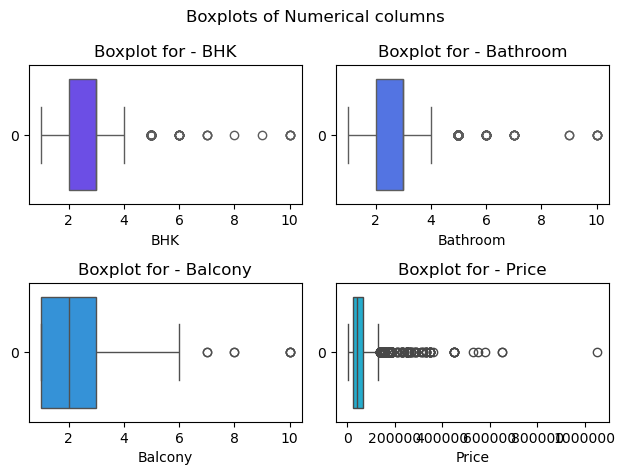

In [150]:
# Plot all box plots 
fig, axs = plt.subplots(nrows=2, ncols=2)
#print(axs.flatten()) 

pos = axs.flatten() 

for i in range(len(num_cols)): 
    sns.boxplot(data=df, x = num_cols[i], ax = pos[i], color=sns.color_palette("rainbow", 14)[i])
    pos[i].set_title(f"Boxplot for - {num_cols[i]}")
    pos[i].yaxis.set_major_formatter(mticker.ScalarFormatter())
    pos[i].ticklabel_format(style='plain')
    
plt.suptitle("Boxplots of Numerical columns")
plt.tight_layout()
plt.show();

In [151]:
#df.to_csv(r'C:\Users\91630\Innomatics-DA\Project\magicbricks_cleaneddata.csv',index=False)

In [2]:
df = pd.read_csv(r'C:\Users\91630\Innomatics-DA\Project\magicbricks_cleaneddata.csv')

### Data Analysis and visualization (EDA)

##### Categorical:
+ Residential_type
+ Furnishing
+ Tenants_preferred
+ Posted_by
+ City

##### Numerical:
+ BHK                
+ Bathroom    
+ Balcony
+ Price


#### Univariate Analysis

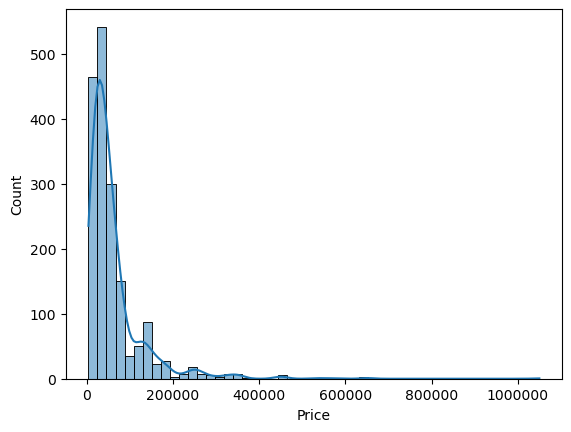

In [152]:
sns.histplot(df["Price"], bins=50, kde=True)
plt.ticklabel_format(style='plain'); 

###### Observations:Histogram of Rental Prices
+ The distribution is right-skewed, meaning most properties are in the lower price range.
+ A majority of properties fall below ₹80,000, while a few luxury rentals exceed ₹2,00,000.

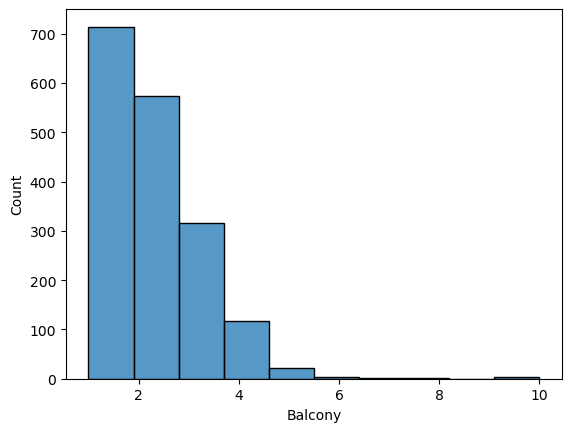

In [153]:
sns.histplot(data= df, x= 'Balcony', bins= 10);

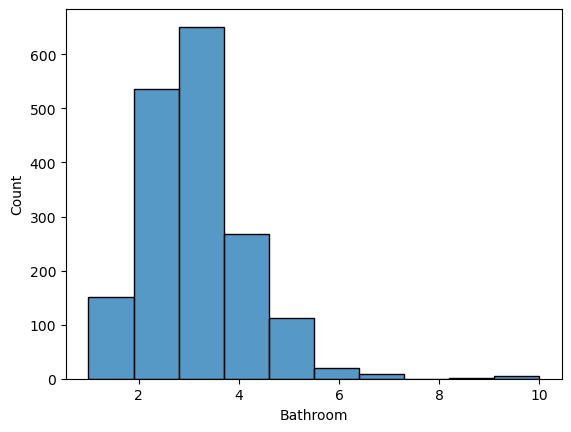

In [154]:
sns.histplot(data= df, x= 'Bathroom', bins= 10);

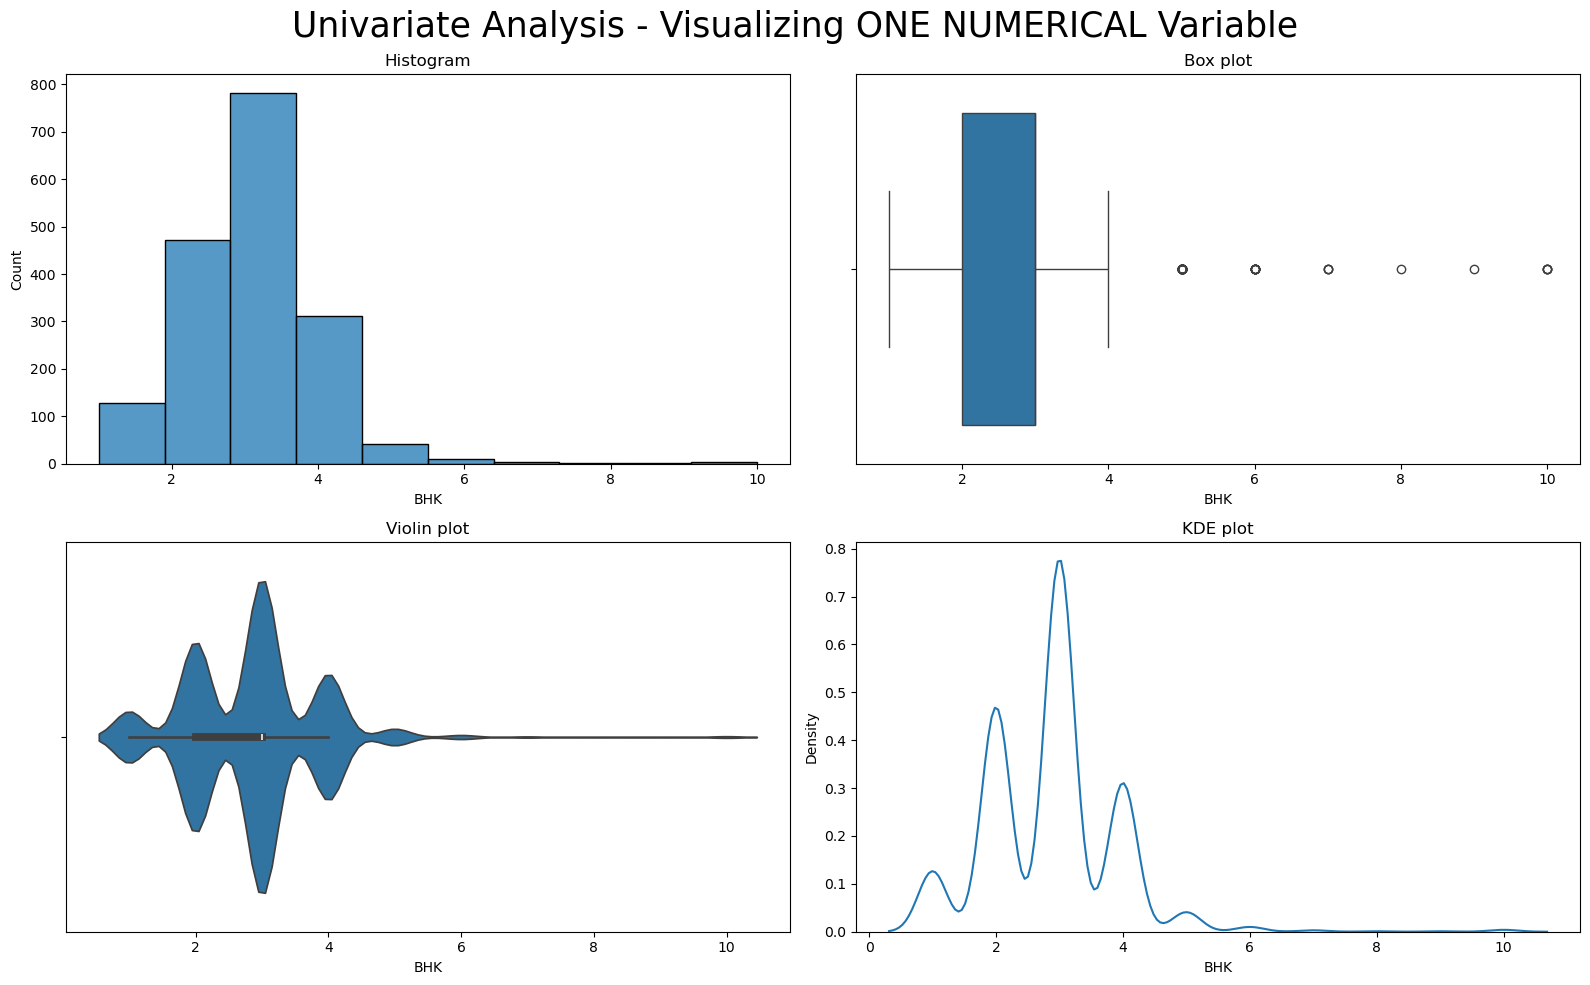

In [155]:
# PLots with ONE NUMERICAL variable - Histogram, Box, Violin, KDE plots 
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
sns.histplot(data=df, x = "BHK", bins =10, ax = axs[0,0]) 
axs[0,0].set_title("Histogram")

sns.boxplot(data=df, x = "BHK",  ax = axs[0,1])
axs[0,1].set_title("Box plot")

sns.violinplot(data=df, x = "BHK",  ax = axs[1,0])
axs[1,0].set_title("Violin plot")

sns.kdeplot(data=df, x = "BHK",  ax = axs[1,1]) 
axs[1,1].set_title("KDE plot")

plt.suptitle("Univariate Analysis - Visualizing ONE NUMERICAL Variable", fontsize = 25)
plt.tight_layout()
plt.show();

Observations:

+ 2 BHK and 3 BHK properties are the most common.

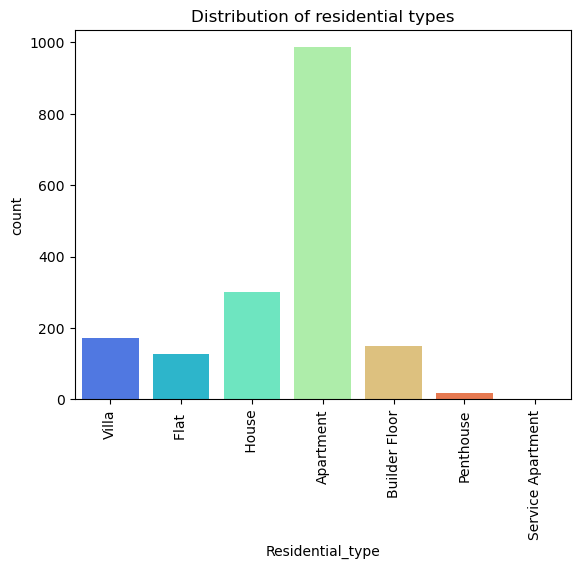

In [176]:
sns.countplot(data=df, x = "Residential_type", palette=sns.color_palette("rainbow"))
plt.title('Distribution of residential types')
plt.xticks(rotation=90);

Observations:
+ Most listings are of apartments

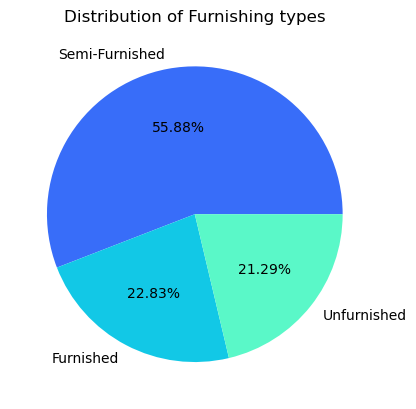

In [177]:
plt.pie(df.Furnishing.value_counts().values, labels=df.Furnishing.value_counts().index, autopct="%.2f%%", colors=sns.color_palette("rainbow"))
plt.title('Distribution of Furnishing types');

Observations:

+ Most properties are semi-furnished

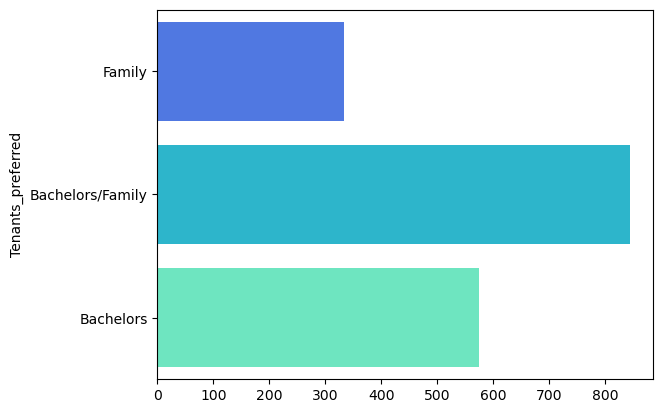

In [158]:
sns.barplot(df.Tenants_preferred, estimator=np.size, ci = False, palette=sns.color_palette("rainbow"));

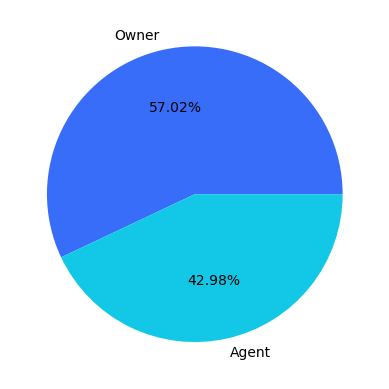

In [159]:
plt.pie(df.Posted_by.value_counts().values, labels=df.Posted_by.value_counts().index, autopct="%.2f%%", colors=sns.color_palette("rainbow"));

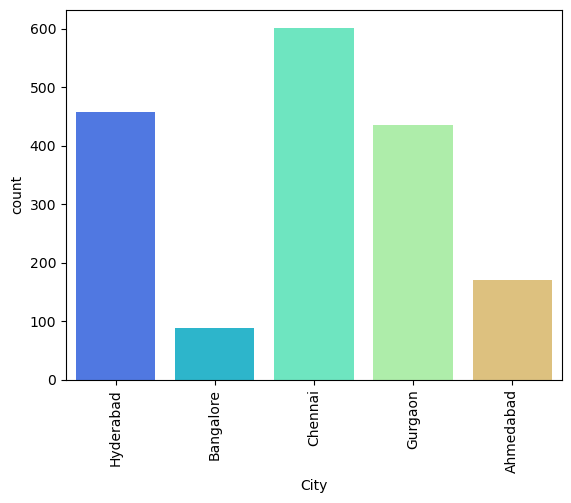

In [160]:
sns.countplot(data=df, x = "City", palette=sns.color_palette("rainbow"))
plt.xticks(rotation=90);

#### Bivariate Analysis

###### Numerical vs numerical

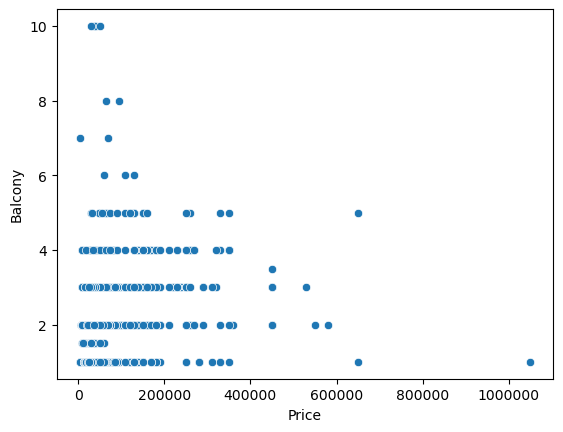

In [161]:
sns.scatterplot(data=df, x = "Price", y = "Balcony")
plt.ticklabel_format(style='plain');

In [162]:
df.corr(numeric_only=True)

,BHK,Bathroom,Balcony,Price
BHK,1.000000,0.869034,0.473385,0.402916
Bathroom,0.869034,1.000000,0.461213,0.453455
Balcony,0.473385,0.461213,1.000000,0.259097
Price,0.402916,0.453455,0.259097,1.000000


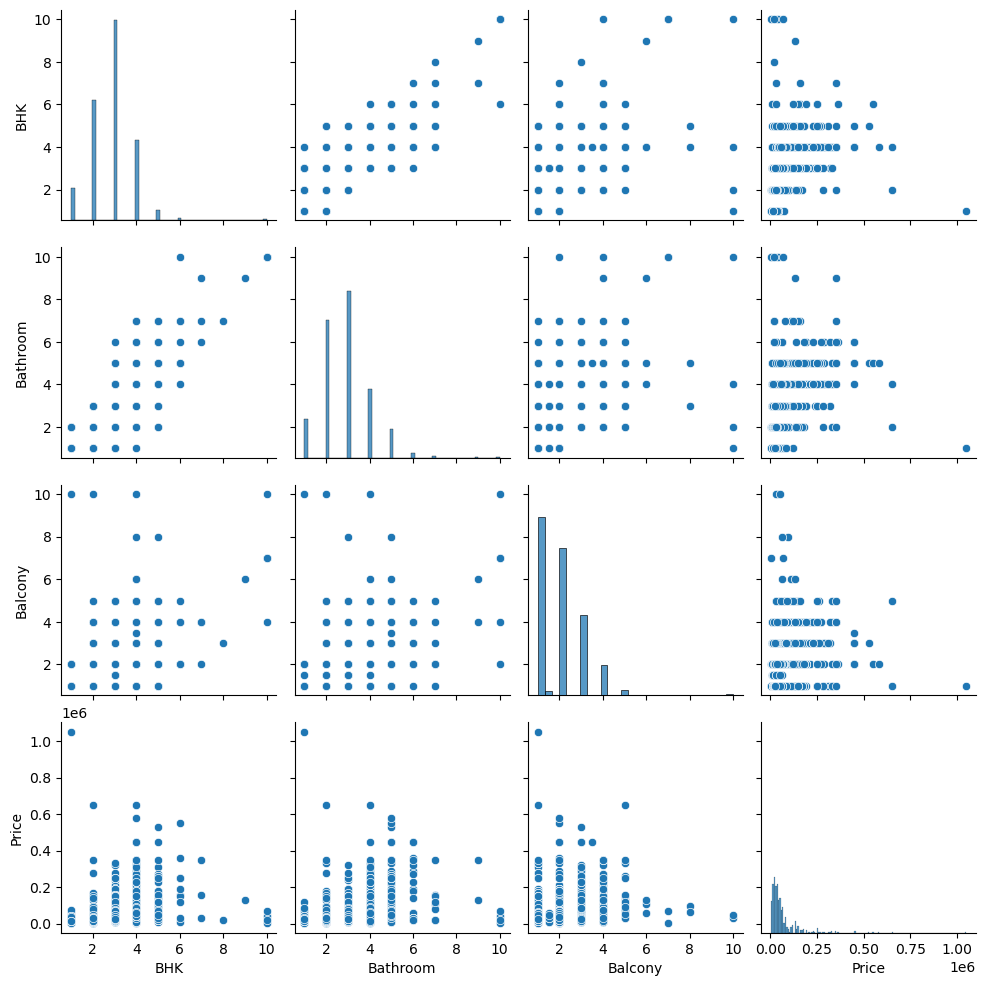

In [163]:
sns.pairplot(df);

##### Categorical vs categorical

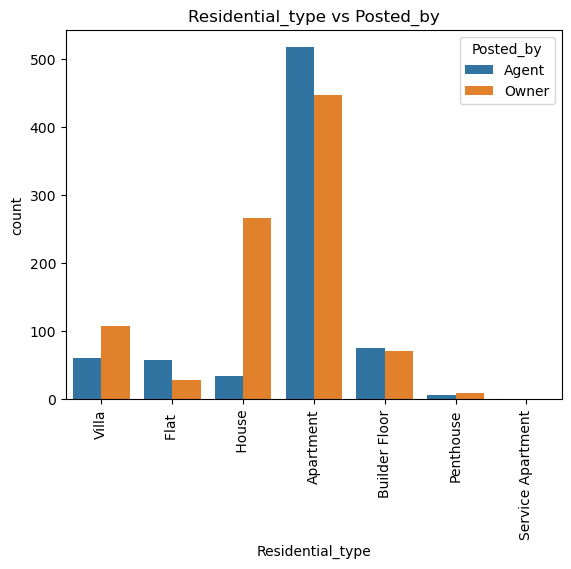

In [29]:
sns.countplot(data = df, x = "Residential_type", hue = "Posted_by")
plt.title('Residential_type vs Posted_by')
plt.xticks(rotation=90);

Observations:

+ Most of the Houses are posted by owners

In [165]:
pd.crosstab(df.Tenants_preferred, df.Residential_type) 

Residential_type,House,Apartment,Builder Floor,Flat,Penthouse,Service Apartment,Villa
Tenants_preferred,,,,,,,
Bachelors,89,338,63,27,8,1,49
Bachelors/Family,177,456,69,55,7,0,80
Family,36,191,17,44,3,0,42


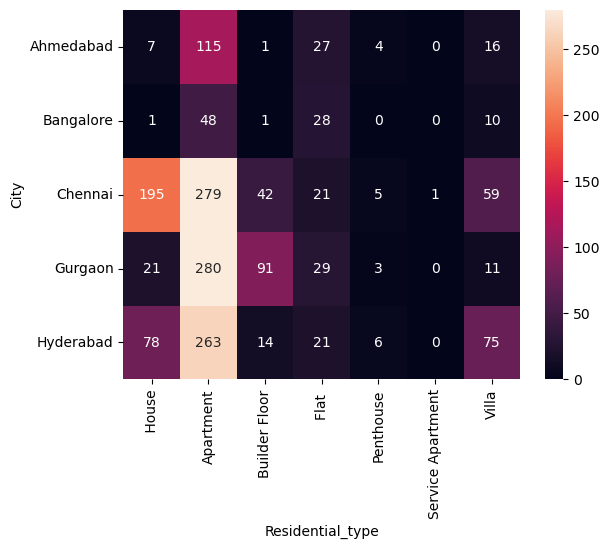

In [166]:
matrix_data = pd.crosstab(df.City, df.Residential_type)  
sns.heatmap(matrix_data, annot = True, fmt = "d");

##### Categorical vs numerical

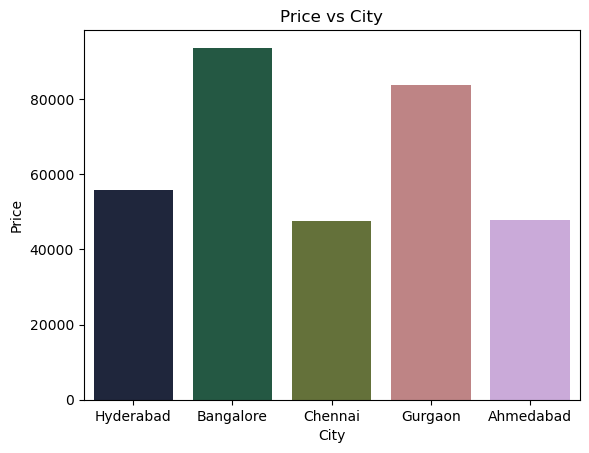

In [180]:
sns.barplot(data= df, x= 'City', y= 'Price', ci= False, palette=sns.color_palette("cubehelix"))
plt.title('Price vs City');

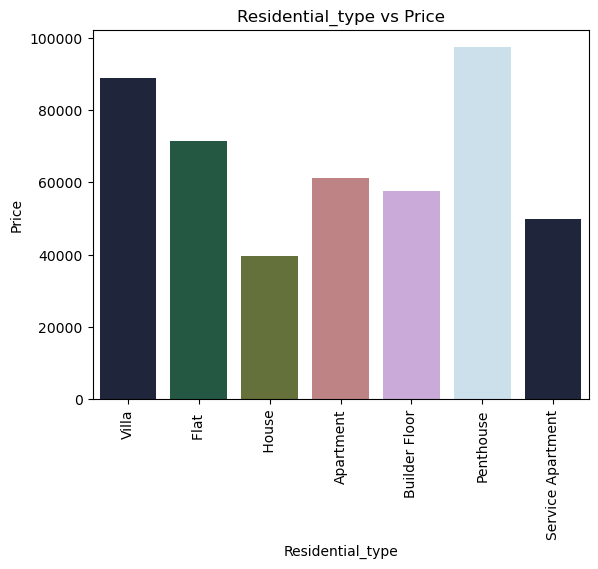

In [6]:
sns.barplot(data= df, x= 'Residential_type', y= 'Price', ci= False, palette=sns.color_palette("cubehelix"))
plt.title('Residential_type vs Price')
plt.xticks(rotation = 90);

Observations:

+ Bangalore & Gurgaon have the highest rents

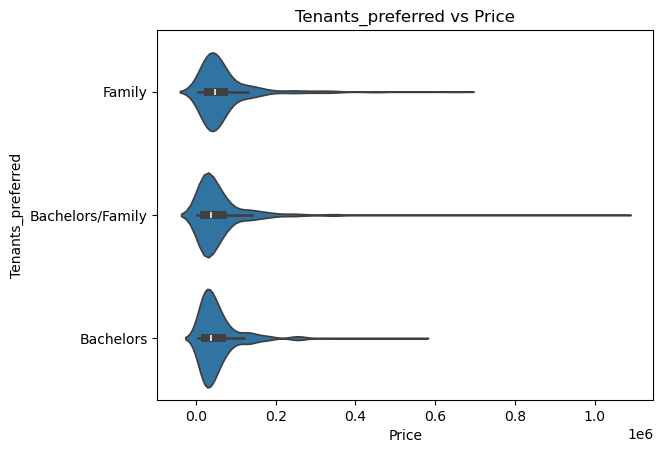

In [168]:
plt.title("Tenants_preferred vs Price")
sns.violinplot(data=df, x="Price", y= "Tenants_preferred");

In [169]:
df.groupby('Residential_type')['BHK'].sum()

Residential_type
 House                784
Apartment            2750
Builder Floor         411
Flat                  376
Penthouse              58
Service Apartment       1
Villa                 626
Name: BHK, dtype: int32

In [170]:
pd.pivot_table(df, values="Price", index="BHK", columns="City", aggfunc="mean")

City,Ahmedabad,Bangalore,Chennai,Gurgaon,Hyderabad
BHK,,,,,
1,14500.000000,29333.333333,27254.296296,30027.777778,16778.260870
2,26607.142857,43000.000000,30010.664032,37761.206897,28205.504587
3,35866.847826,86720.000000,56351.282051,65941.552511,50282.278761
4,81886.046512,185000.000000,93015.094340,136616.935484,110841.463415
5,104000.000000,490000.000000,95454.545455,156000.000000,101538.461538
6,NaN,NaN,249833.333333,186666.666667,10000.000000
7,NaN,NaN,350000.000000,30000.000000,160000.000000
8,NaN,NaN,20000.000000,NaN,NaN
9,NaN,NaN,NaN,130000.000000,NaN


Observations:
+ Bangalore has the highest average rent for 4+ BHK properties.
+ 2 BHK and 3 BHK are the most common configurations, with Hyderabad and Chennai having relatively affordable rental prices.
+ Gurgaon and Bangalore tend to have higher rental prices for larger properties.

#### Multivariate Analysis

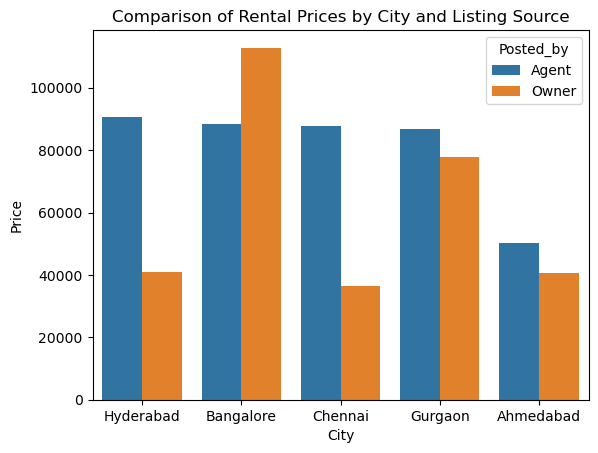

In [183]:
sns.barplot(data=df, x = "City", y = "Price", estimator=np.mean, ci = False, hue = "Posted_by")
plt.title('Comparison of Rental Prices by City and Listing Source');

Observations:
+ Most of the listings from banglore are posted by owners
+ whereas in hyderabad, most of the listingsare posted by agents

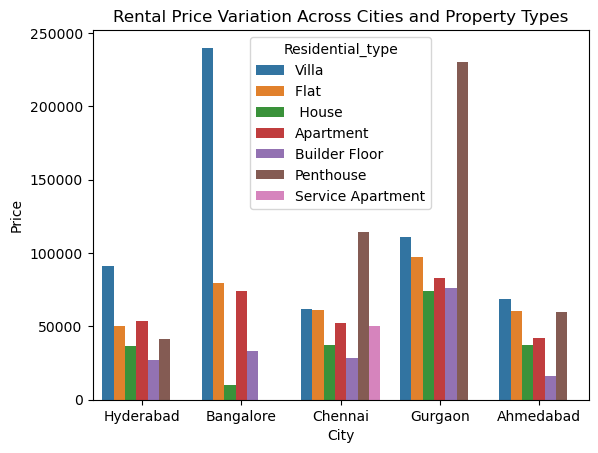

In [184]:
sns.barplot(data=df, x = "City", y = "Price", estimator=np.mean, ci = False, hue = "Residential_type")
plt.title('Rental Price Variation Across Cities and Property Types');

Observations:
+ In Bangalore, Villas are more pricier
+ And in Gurgaon, Penthouses are more pricier

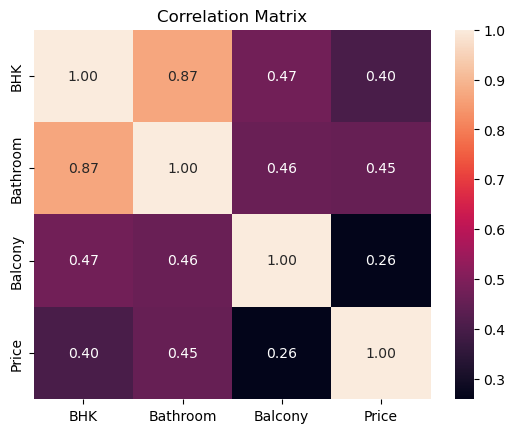

In [181]:
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt = ".2f")
plt.title('Correlation Matrix');

Observations:
+ Price & BHK show a strong positive correlation (as expected).
+ Bathroom count is also correlated with price, indicating larger homes tend to have more bathrooms.
+ Furnishing type has a weak correlation with price, meaning other factors like location and size matter more.